<h1 align='center'><b>Final Project: Sentiment Analysis</b></h1>

---




# About the dataset:
This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| id            | Tweet's id                                                                                      |
| entity          | subject                                                                                          |
| sentiment         | sentiment: positive, negative and neutral                                                                                  |
| body      | Tweet/message content                                                                                           |

# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
from joblib import dump
from joblib import load
print('Done')

Done


# **Remove warnings**

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# **Data Collection**

* **Load Dataset and adding the related headers**

In [3]:
column_names = ['id', 'entity', 'sentiment', 'body']
dataset = pd.read_csv('twitter_training.csv', names= column_names)
valid = pd.read_csv('twitter_validation.csv', names = column_names)
df = pd.concat([dataset, valid], axis=0, ignore_index=True)
df.head(3)

,id,entity,sentiment,body
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


* **Drop the unwanted columns**

In [4]:
df = dataset.drop(['id', 'entity'], axis=1)
df.head(3)

,sentiment,body
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


# **Data Analysis**

* **Some information for data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  74682 non-null  object
 1   body       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


* **Calculate null value**

In [6]:
df.isna().sum()

sentiment      0
body         686
dtype: int64

* **Drop null values**

In [7]:
df.dropna(inplace=True)
df.isna().sum()

sentiment    0
body         0
dtype: int64

* **Shape of data**

In [8]:
df.shape

(73996, 2)

* **Check for duplicated values**

In [9]:
df.duplicated().sum()

4227

* **Remove duplicated rows**

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

* **Describtion of data**

In [11]:
df.describe()

,sentiment,body
count,69769,69769
unique,4,69491
top,Negative,It
freq,21237,4


* **Change data type from object to string**

In [12]:
df = df.astype({'body': 'string', 'sentiment': 'string'})
df.dtypes

sentiment    string[python]
body         string[python]
dtype: object

# **Visuallizing the data for further analysis**

* **Check the data balance**

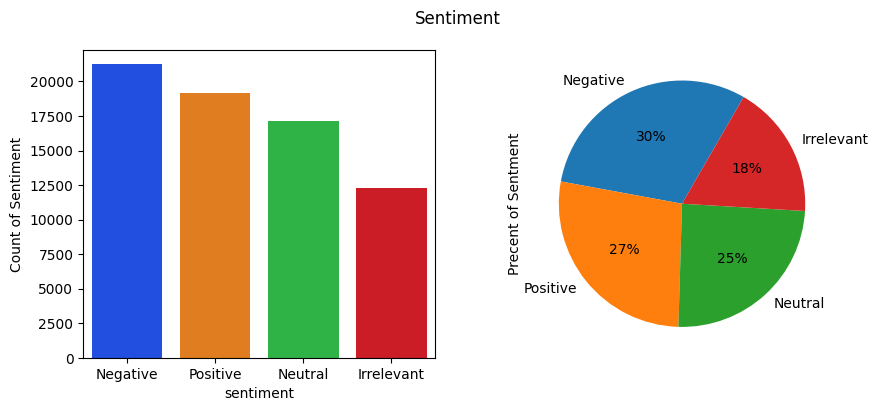

In [13]:
fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts(),palette='bright', ax=ax[0])
ax[0].set_ylabel('Count of Sentiment')
df['sentiment'].value_counts().plot.pie(autopct='%1.0f%%',startangle=60, ax=ax[1])
ax[1].set_ylabel('Precent of Sentment')
fig.suptitle('Sentiment')
plt.show()

* **Find the most common words that may affect the model**

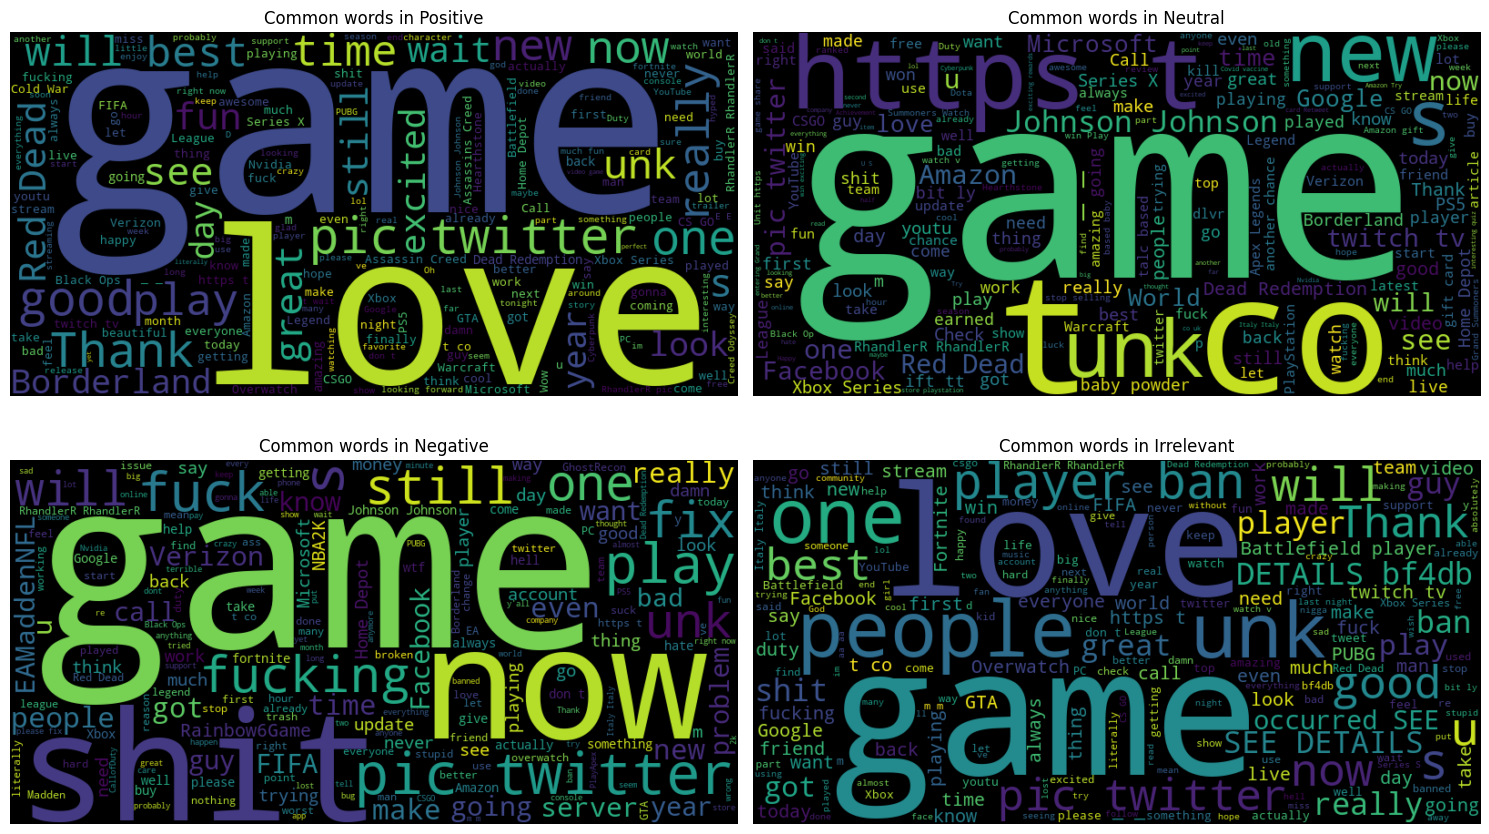

In [14]:
fig , ax = plt.subplots(2,2,figsize=(15,9))

for i, label in enumerate(df['sentiment'].unique()):
    text = ' '.join(df[df['sentiment']==label]['body'])
    # print(text, end ='\n\n')
    wordcloud = WordCloud(width=800, height=400).generate(text)
    row = i // 2
    col = i % 2
    ax[row][col].imshow(wordcloud, interpolation='bilinear')
    ax[row][col].axis('off')
    ax[row][col].set_title(f"Common words in {label}")
plt.tight_layout()
plt.show()

* **Analyze common words sequence**

In [15]:
for label in df['sentiment'].unique():
  vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
  ngrams = vectorizer.fit_transform(df[df['sentiment'] == label]['body'])
  sum_ngrams = ngrams.sum(axis=0)
  words_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  # Top 8 n-grams
  print(label,':')
  print(words_freq[:8], '\n')

Positive :
[('game', 2262), ('com', 1846), ('love', 1709), ('just', 1666), ('good', 1551), ('like', 1323), ('really', 1266), ('pic', 1257)] 

Neutral :
[('com', 4089), ('johnson', 1880), ('just', 1595), ('amazon', 1373), ('https', 1353), ('game', 1310), ('facebook', 992), ('like', 907)] 

Negative :
[('game', 3777), ('just', 2184), ('com', 1814), ('like', 1621), ('shit', 1466), ('twitter', 1323), ('fix', 1309), ('pic', 1282)] 

Irrelevant :
[('com', 1821), ('player', 1127), ('just', 1116), ('ban', 990), ('like', 987), ('game', 802), ('people', 729), ('love', 669)] 



* **Make a copy from the DataFrame**

In [16]:
df_copy = df.copy()

* **Calculate punctuation percentage**

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

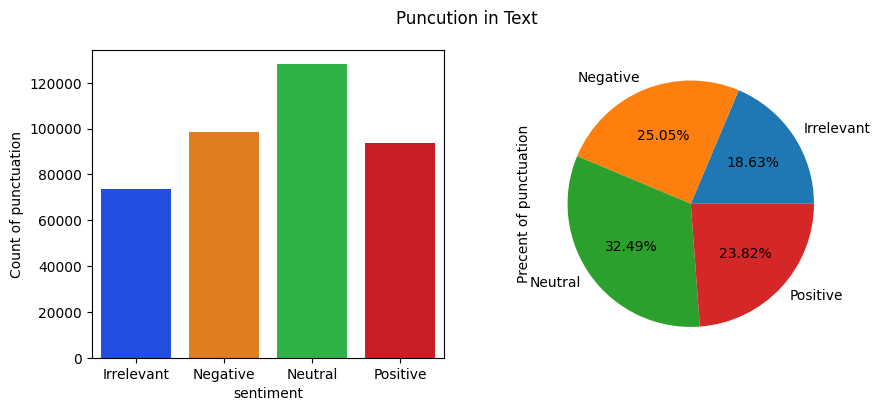

In [18]:
def count_punct(txt):
    count = sum([1 for i in txt if i in string.punctuation])
    return count

df_copy['count_punct'] = df_copy['body'].apply(lambda x : count_punct(x))
punct = df_copy.groupby('sentiment')['count_punct'].sum().reset_index()
punct['punct_precent'] = round((punct['count_punct'] / (punct['count_punct'].sum()) )*100, 2)
# print(punct)

fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=punct['sentiment'], y=punct['count_punct'],palette='bright', ax=ax[0])
ax[0].set_ylabel('Count of punctuation')
punct['punct_precent'].plot.pie(labels=punct['sentiment'], autopct='%1.02f%%',startangle=0, ax=ax[1])
ax[1].set_ylabel('Precent of punctuation')

fig.suptitle('Puncution in Text')

plt.show()

* **Calculate count of links**

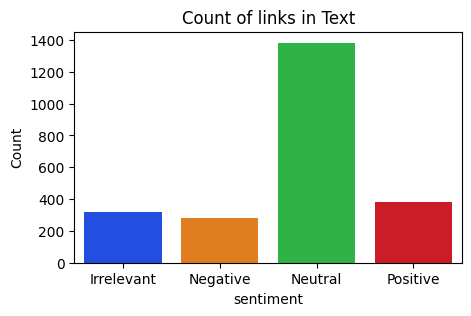

In [19]:
def count_link(txt):
    count = len(re.findall(r"\b(https?)",txt))
    return count

df_copy['count_link'] = df_copy['body'].apply(lambda x : count_link(x))
links = df_copy.groupby('sentiment')['count_link'].sum().reset_index()

plt.figure(figsize = (5,3))
sns.barplot(x=links['sentiment'], y=links['count_link'],palette='bright')
plt.title('Count of links in Text')
plt.ylabel('Count')
plt.show()

* **Calculate count of digits**

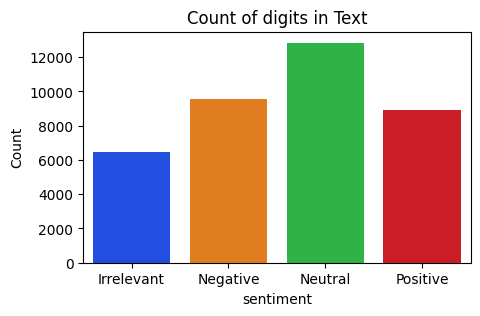

In [20]:
def count_digit(txt):
    count = len(re.findall(r"\b(one|two|three|four|five|six|seven|eight|nine|ten|\d+)\b",txt))
    return count

df_copy['count_digit'] = df_copy['body'].apply(lambda x : count_digit(x))
digit = df_copy.groupby('sentiment')['count_digit'].sum().reset_index()

plt.figure(figsize = (5,3))
sns.barplot(x=digit['sentiment'], y=digit['count_digit'],palette='bright')
plt.title('Count of digits in Text')
plt.ylabel('Count')
plt.show()

* **calculate count of length in each sentiment**

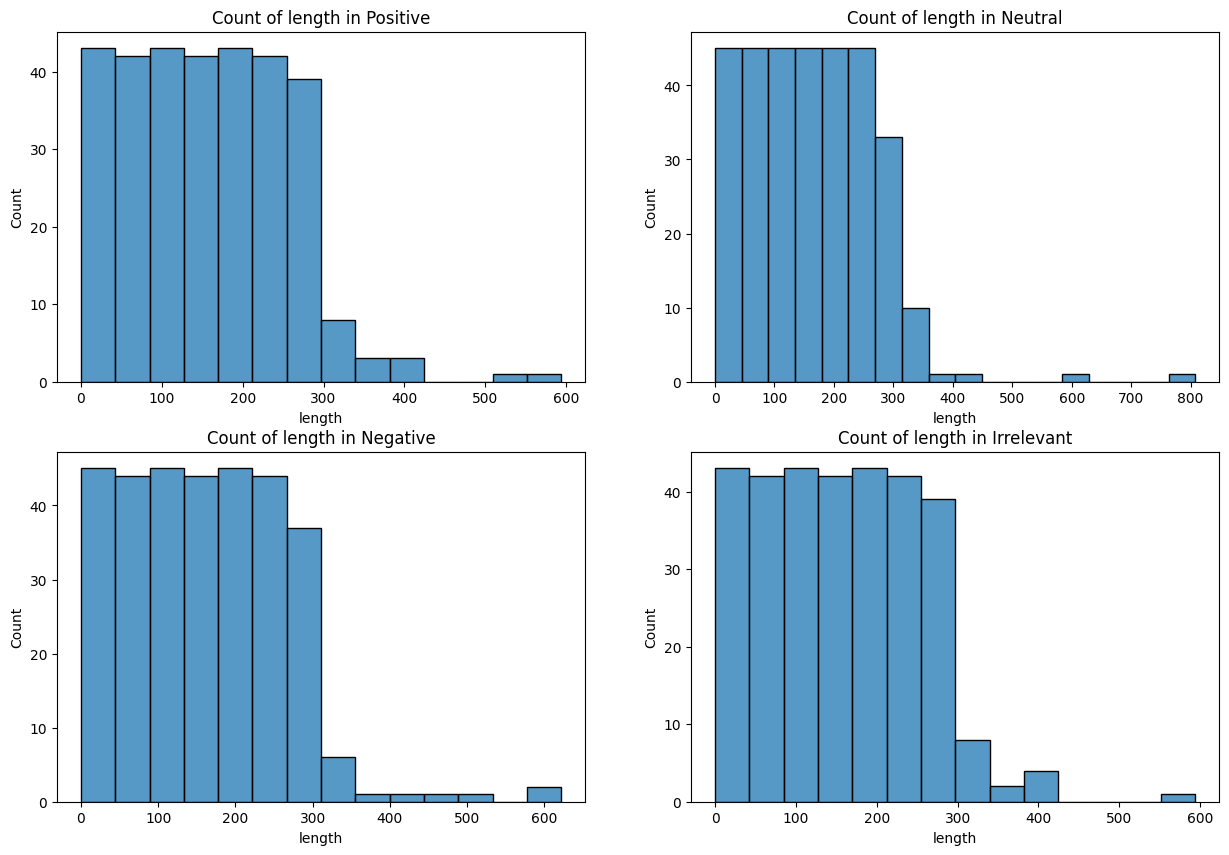

In [21]:
fig , ax = plt.subplots(2,2,figsize=(15,10))
df_copy['length'] = df_copy['body'].apply(lambda x : len(x)- x.count(' '))

for i, label in enumerate(df['sentiment'].unique()):
    length = df_copy[df_copy['sentiment'] == label].groupby('sentiment')['length'].value_counts().reset_index()
    row = i // 2
    col = i % 2
    sns.histplot(length['length'] ,ax =ax[row][col])
    ax[row][col].set_title(f"Count of length in {label}")
plt.show()

---

# Insights

* **The data is balanced**
* **There are common words we need to remove from each category(ex: game, like, com...)**
* **Remove punctuation**
* **Don't remove Links**
* **Remove digits and numbers**
* **Don't add lengh as a feature**

---


# **Data Preprocessing**

* ***Step 1:* convert all string to lowercase**

In [22]:
df['body'] = df['body'].apply(lambda x: x.lower())
df.head(3)

,sentiment,body
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...


* ***Step 2:* Remove stop words and some common words**

In [23]:
#Define stop words and common words
common_words = set(['game', 'com', 'unk', 'like'])
stop_words = set(stopwords.words('english')).union(common_words)
#function to remove stop words
def remove_stop_words(txt):
    return ' '.join([x for x in txt.split() if x not in stop_words])

df['body'] = df['body'].apply(lambda x: remove_stop_words(x))
df.head(3)

,sentiment,body
0,Positive,"im getting borderlands murder ,"
1,Positive,"coming borders kill all,"
2,Positive,"im getting borderlands kill all,"


* ***Step 3:* Remove punctuation**

In [24]:
#Function to remove punctuation
def remove_punc(txt):
    text_non_punct = "".join([char for char in txt if char not in string.punctuation])
    return text_non_punct

df['body'] = df['body'].apply(lambda x: remove_punc(x))
df.head(3)

,sentiment,body
0,Positive,im getting borderlands murder
1,Positive,coming borders kill all
2,Positive,im getting borderlands kill all


* ***Step 4:* Remove digit and numbers**

In [25]:
def remove_digit(txt):
    text_non_digit = re.sub(r"\b(one|two|three|four|five|six|seven|eight|nine|ten|\d+)\b", '',txt).strip()
    return text_non_digit

df['body'] = df['body'].apply(lambda x: remove_digit(x))
df.head(3)

,sentiment,body
0,Positive,im getting borderlands murder
1,Positive,coming borders kill all
2,Positive,im getting borderlands kill all


* ***Step 5:* Tokenization**

In [26]:
df['body'] = df['body'].apply(lambda x: word_tokenize(x))
df.head(3)

,sentiment,body
0,Positive,"[im, getting, borderlands, murder]"
1,Positive,"[coming, borders, kill, all]"
2,Positive,"[im, getting, borderlands, kill, all]"


* ***Step 6:* Apply Lemmatizing**

In [27]:
lem = WordNetLemmatizer()
#function to lemmatize
def lemmatizing (txt):
    lemmtize = [lem.lemmatize(word,pos='v') for word in txt]
    return lemmtize

df['body'] = df['body'].apply(lambda x: lemmatizing(x))
df.head()

,sentiment,body
0,Positive,"[im, get, borderlands, murder]"
1,Positive,"[come, border, kill, all]"
2,Positive,"[im, get, borderlands, kill, all]"
3,Positive,"[im, come, borderlands, murder, all]"
4,Positive,"[im, get, borderlands, murder, all]"


* ***Step 7:* Return from tokenization to text**

In [28]:
df['body'] = df['body'].apply(lambda x: ' '.join(x))
df.head(3)

,sentiment,body
0,Positive,im get borderlands murder
1,Positive,come border kill all
2,Positive,im get borderlands kill all


* ***Step 8:* Split DataFrame to train model**

In [29]:
target = df['sentiment']
df.drop(columns=['sentiment'], inplace=True)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, shuffle=True)

* ***Step 9:* Apply TF-IDF**

In [31]:
TFIDF = TfidfVectorizer(ngram_range=(1, 2))
tfidf_train = TFIDF.fit_transform(x_train['body'])
tfidf_test = TFIDF.transform(x_test['body'])

**Save TF-IDF**

In [32]:
joblib.dump(TFIDF, 'TFIDF_model.pkl')

['TFIDF_model.pkl']

#  **Model selection**

*   **KNN**
*   **Decision Trees**
*   **SVM**
*   **Logistic Regression**
*   **Random Forest**



## **KNN**

* **Model Training**

In [32]:
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(tfidf_train, y_train)

KNeighborsClassifier()

* **Make Prediction**

In [33]:
yhat_train = knn.predict(tfidf_train)
yhat_test = knn.predict(tfidf_test)

* **Evaluation of the model on train data**

In [34]:
accuracy_knn_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_knn_train:.2f}')

Train Accuracy: 0.85


* **Evaluation of the model on test data**

In [35]:
accuracy_knn_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_knn_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.78
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.77      0.79      0.78      2479
    Negative       0.79      0.82      0.81      4294
     Neutral       0.74      0.77      0.75      3454
    Positive       0.82      0.74      0.78      3727

    accuracy                           0.78     13954
   macro avg       0.78      0.78      0.78     13954
weighted avg       0.78      0.78      0.78     13954



* **Confusion Matrix**

[[1954  160  206  159]
 [ 210 3542  313  229]
 [ 175  417 2651  211]
 [ 183  366  408 2770]]


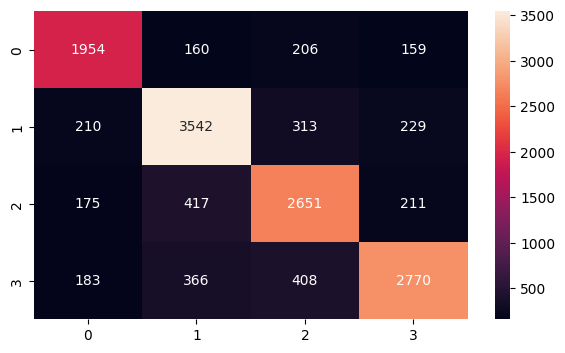

In [36]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Descision Tree**

* **Model Training**

In [37]:
decision_tree = DecisionTreeClassifier(random_state= 0)
decision_tree.fit(tfidf_train, y_train) 

DecisionTreeClassifier(random_state=0)

* **Make Prediction**

In [38]:
yhat_train = decision_tree.predict(tfidf_train)
yhat_test = decision_tree.predict(tfidf_test)

* **Evaluation of the model on train data**

In [39]:
accuracy_dt_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_dt_train:.2f}')

Train Accuracy: 0.99


* **Evaluation of the model on test data**

In [40]:
accuracy_dt_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_dt_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.77
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.76      0.70      0.73      2479
    Negative       0.80      0.82      0.81      4294
     Neutral       0.76      0.74      0.75      3454
    Positive       0.76      0.80      0.78      3727

    accuracy                           0.77     13954
   macro avg       0.77      0.76      0.77     13954
weighted avg       0.77      0.77      0.77     13954



* **Confusion Matrix**

[[1724  228  229  298]
 [ 154 3508  306  326]
 [ 188  377 2553  336]
 [ 194  290  258 2985]]


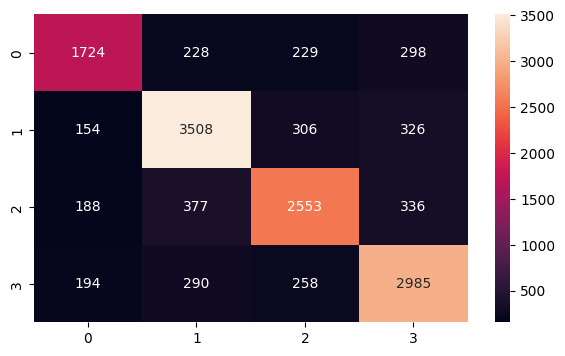

In [41]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **SVM**

* **Grid Search for SVM**

In [32]:
param_grid = {
    'kernel': ['linear', 'sigmoid'],
    'C': [0.1, 1],
    'gamma': [0.1, 1], 
    'random_state': [0],
}

model = SVC()

grid_search = GridSearchCV(model, param_grid, cv=5) 
grid_search.fit(tfidf_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0}
Best cross-validation score:  0.9087521275642748


* **Model Training**

In [33]:
svm = SVC(kernel= 'linear', gamma=0.1, C=1, random_state= 0)
svm.fit(tfidf_train, y_train)

SVC(C=1, gamma=0.1, kernel='linear', random_state=0)

* **Make Prediction**

In [35]:
yhat_train = svm.predict(tfidf_train)
yhat_test = svm.predict(tfidf_test)

* **Evaluation of the model on validation data**

In [36]:
accuracy_svm_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_svm_train:.2f}')

Train Accuracy: 0.98


* **Evaluation of the model on test data**

In [37]:
accuracy_svm_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_svm_test:.2f}')
print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.93
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.93      0.90      0.92      2480
    Negative       0.93      0.94      0.94      4221
     Neutral       0.92      0.92      0.92      3441
    Positive       0.92      0.93      0.92      3812

    accuracy                           0.93     13954
   macro avg       0.93      0.92      0.92     13954
weighted avg       0.93      0.93      0.93     13954



* **Confusion Matrix**

[[2235   64   71  110]
 [  49 3967  109   96]
 [  55   99 3179  108]
 [  57  113  105 3537]]


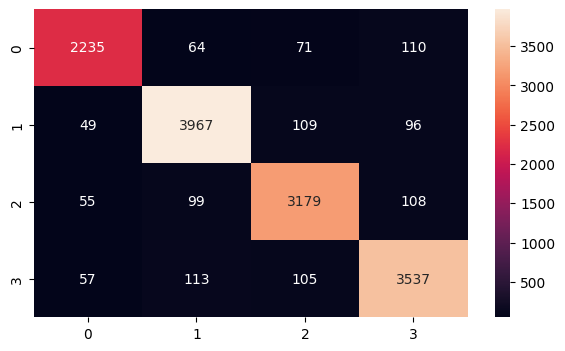

In [38]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Logistic Regression**

* **Model Training**

In [40]:
logistic_reg = LogisticRegression()
logistic_reg.fit(tfidf_train, y_train)

LogisticRegression()

* **Make Prediction**

In [41]:
yhat_train = logistic_reg.predict(tfidf_train)
yhat_test = logistic_reg.predict(tfidf_test)

* **Evaluation of the model on train data**

In [42]:
accuracy_lr_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_lr_train:.2f}')

Train Accuracy: 0.95


* **Evaluation of the model on test data**

In [43]:
accuracy_lr_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_lr_test:.2f}')
print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.86
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.91      0.77      0.83      2461
    Negative       0.85      0.91      0.88      4240
     Neutral       0.87      0.84      0.85      3435
    Positive       0.84      0.88      0.86      3818

    accuracy                           0.86     13954
   macro avg       0.87      0.85      0.86     13954
weighted avg       0.86      0.86      0.86     13954



* **Confusion Matrix**

[[1885  192  130  254]
 [  58 3878  150  154]
 [  55  260 2899  221]
 [  69  214  171 3364]]


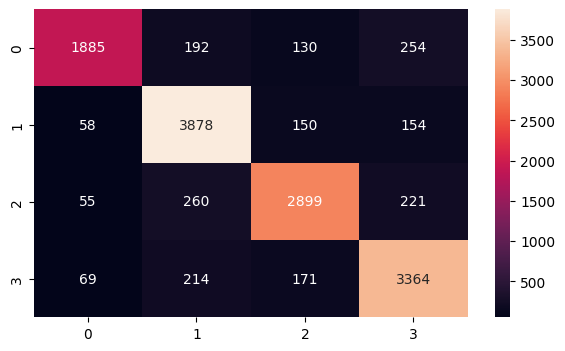

In [44]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Random Forest**

* **Model Training**

In [34]:
random_forest = RandomForestClassifier(n_estimators= 110, random_state = 0)
random_forest.fit(tfidf_train, y_train)

RandomForestClassifier(n_estimators=110, random_state=0)

* **Make Prediction**

In [35]:
yhat_train = random_forest.predict(tfidf_train)
yhat_test = random_forest.predict(tfidf_test)

* **Evaluation of the model on train data**

In [36]:
accuracy_rf_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_rf_train:.2f}')

Train Accuracy: 0.99


* **Evaluation of the model on test data**

In [37]:
accuracy_rf_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_rf_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.91
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.97      0.83      0.89      2461
    Negative       0.90      0.95      0.92      4240
     Neutral       0.91      0.88      0.90      3435
    Positive       0.87      0.93      0.90      3818

    accuracy                           0.91     13954
   macro avg       0.91      0.90      0.90     13954
weighted avg       0.91      0.91      0.91     13954



* **Confusion Matrix**

[[2033  134  101  193]
 [  18 4011   91  120]
 [  25  157 3034  219]
 [  21  131  110 3556]]


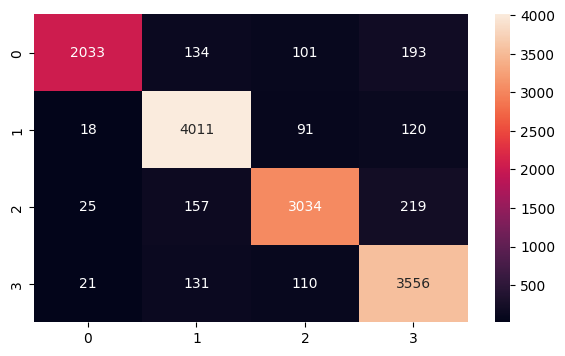

In [38]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Save the models**

In [57]:
joblib.dump(random_forest, 'random_forest_model.pkl')
joblib.dump(logistic_reg, 'logistic_reg_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(decision_tree, 'decision_tree_model.pkl')
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']

## **Plotting Train vs Test Set Accuracies**

In [58]:
accuracies = {
    'KNN': [accuracy_knn_train, accuracy_knn_test],             
    'Decision Tree': [accuracy_dt_train, accuracy_dt_test],    
    'SVM': [accuracy_svm_train, accuracy_svm_test],              
    'Logistic Regression': [accuracy_lr_train, accuracy_lr_test], 
    'Random Forest': [accuracy_rf_train, accuracy_rf_test] 
}
accuracies_df = pd.DataFrame(accuracies)

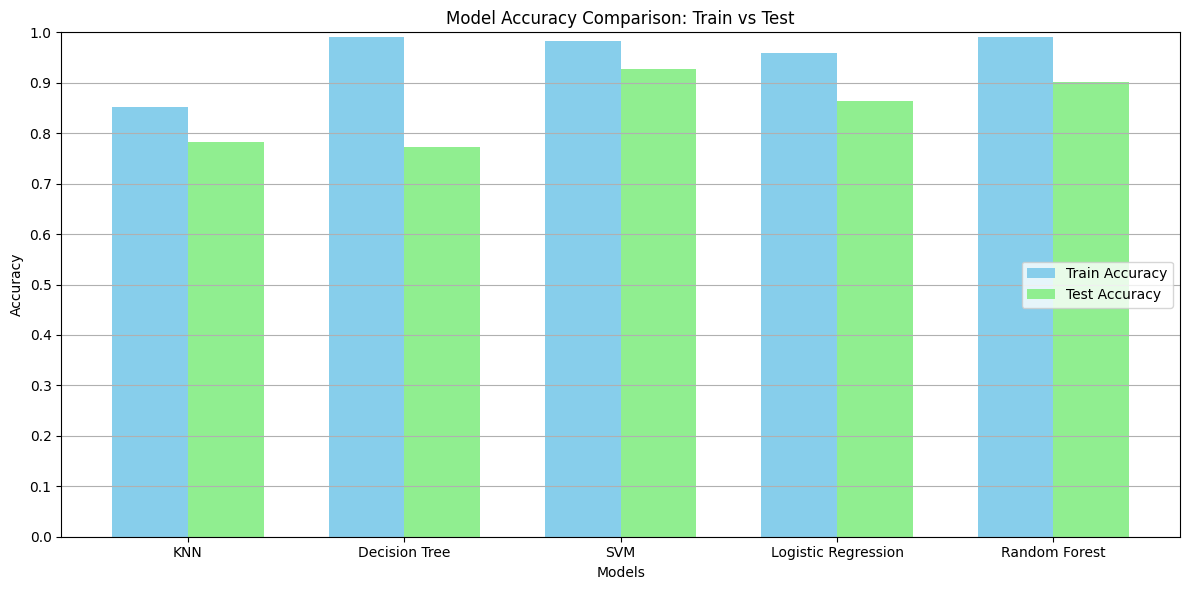

In [59]:
models = list(accuracies.keys())
train_accuracies = list(accuracies_df.iloc[0])
test_accuracies = list(accuracies_df.iloc[1])

bar_width = 0.35

x = np.arange(len(models))

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, train_accuracies, bar_width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width/2, test_accuracies, bar_width, label='Test Accuracy', color='lightgreen')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Train vs Test')
plt.xticks(x, models)
plt.ylim(0, 1)  
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc = 'right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# **Deployments**